<a href="https://colab.research.google.com/github/hbenatsou/neo_bank/blob/main/Copie_de_NEO_BANQUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.Problèmatique**
Understand task and business needs

Pour une banque l'objectif est de générer du PNB. Pour celà elle a besoin d'avoir des clients actifs/équipés et fidèles. Elle a besoin de garder ses clients  ainsi que d'augmenter son portefeuille client(prospection).

A la vue de nos données et du temps imparti, nous allons nous consacrer sur l'activation des comptes.

**Qui sont nos clients actifs et comment activer nos inactifs?**

Objectif 1: Déterminer les clients actifs pour celà nous avons besoin de définir:

- le nombre de transactions et le montant des transactions par mois (calcul à partir table des transactions/clients)
- voir si il y a une corrélation avec: l'âge, le pays, la date de création, l'utilisation de la crypto... nous allons tester la corrélation entre toutes nos variables(union table des tables, graphique nuage, stats).

Objectif 2 : Voir l'impact des notifiactions pour celà nous avons besoin:
- d'étudier la corrélation avec le device, le nbre de transaction, le montant de transaction union table transcations et device)

- définir quelles sont les notifications qui poussent à l'activation du compte et mesurer leur impact.(augmentation du volume des transactions après l'envoie des notifications)


Objectif 3: Rendre un rapport avec:
- la définition d'un client actif
- des propositions pour rendre les clients inactifs, actifs.


Nous allons mesurer :
-	L’activation avec le taux de conversion
-	La fidélisation avec le DAU/MAU ratio
-	L’équipement avec le nombre d’utilisateur par produit


#**2.Collect_data**

In [2]:
#import des bibliothèques et authorization
import pandas as pd
import numpy as np
#import ploty
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#import matplotlib
import matplotlib.pyplot as plt
#import seaborn
import seaborn
import seaborn as sns



In [3]:
# Pour receuilli nos identifiants
from google.colab import auth
auth.authenticate_user()
#Query Bigquery
#Téchargement table 1 : TRANSACTIONS
query = "SELECT * FROM `pro-tuner-402908.neo_bank.transactions`"
id = "pro-tuner-402908"
transactions_df = pd.read_gbq(query, project_id = id)

# **3.Understand data**

#3.1. Data Analyse

# la Dataframe

In [4]:
transactions_df.head()

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_1973,TOPUP,AED,6079.39,COMPLETED,None,NaN,None,None,INBOUND,user_4773,2018-08-13 21:51:28.670363+00:00
1,transaction_508,TOPUP,AED,298.64,COMPLETED,None,NaN,None,None,INBOUND,user_4773,2018-09-06 18:19:53.401363+00:00
2,transaction_33,TOPUP,AED,236.63,COMPLETED,None,NaN,None,None,INBOUND,user_4773,2018-10-04 09:28:24.287363+00:00
3,transaction_1755306,EXCHANGE,AED,69.92,COMPLETED,None,NaN,None,None,OUTBOUND,user_10943,2018-12-07 19:45:41.208245+00:00
4,transaction_940,EXCHANGE,AED,52.24,COMPLETED,None,NaN,None,None,OUTBOUND,user_1363,2018-12-28 01:29:52.746895+00:00


In [5]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740075 entries, 0 to 2740074
Data columns (total 12 columns):
 #   Column                 Dtype              
---  ------                 -----              
 0   transaction_id         object             
 1   transactions_type      object             
 2   transactions_currency  object             
 3   amount_usd             float64            
 4   transactions_state     object             
 5   ea_cardholderpresence  object             
 6   ea_merchant_mcc        float64            
 7   ea_merchant_city       object             
 8   ea_merchant_country    object             
 9   direction              object             
 10  user_id                object             
 11  created_date           datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), object(9)
memory usage: 250.9+ MB


il n'y a pas de colonne null d'après le df_info cependant nous avons None- NaN

In [6]:
transactions_df.isnull().sum()

transaction_id                 0
transactions_type              0
transactions_currency          0
amount_usd                     0
transactions_state             0
ea_cardholderpresence    1170594
ea_merchant_mcc          1158658
ea_merchant_city         1158794
ea_merchant_country      1158979
direction                      0
user_id                        0
created_date                   0
dtype: int64

In [7]:
#pour connaître le % de valeur null par colonne
transactions_df.isna().mean().sort_values().tail()

created_date             0.000000
ea_merchant_mcc          0.422856
ea_merchant_city         0.422906
ea_merchant_country      0.422973
ea_cardholderpresence    0.427212
dtype: float64

Nous verrons plus tard que les 4 ea sont liés. en fonction d'avoir ou non une carte.

#les colonnes

#Transactions_type

In [8]:
transactions_df['transactions_type'].nunique()

10

In [9]:
transactions_df['transactions_type'].unique()

array(['TOPUP', 'EXCHANGE', 'TRANSFER', 'CARD_PAYMENT', 'CARD_REFUND',
       'ATM', 'CASHBACK', 'REFUND', 'FEE', 'TAX'], dtype=object)

In [10]:
transactions_df['transactions_type'].describe()

count          2740075
unique              10
top       CARD_PAYMENT
freq           1475780
Name: transactions_type, dtype: object

In [11]:
transactions_df['transactions_type'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2740075 entries, 0 to 2740074
Series name: transactions_type
Non-Null Count    Dtype 
--------------    ----- 
2740075 non-null  object
dtypes: object(1)
memory usage: 20.9+ MB


transactions type à relier avec outbound/inbound pour voir les flux créditeurs et débiteurs. Plus relier aux porteurs de cartes.

# Transactions_currency

In [12]:
transactions_df['transactions_currency'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2740075 entries, 0 to 2740074
Series name: transactions_currency
Non-Null Count    Dtype 
--------------    ----- 
2740075 non-null  object
dtypes: object(1)
memory usage: 20.9+ MB


In [13]:
transactions_df['transactions_currency'].unique()

array(['AED', 'AUD', 'BCH', 'BGN', 'BTC', 'CAD', 'CHF', 'CZK', 'DKK',
       'ETH', 'EUR', 'GBP', 'HKD', 'HRK', 'HUF', 'ILS', 'INR', 'JPY',
       'LTC', 'MAD', 'MXN', 'NOK', 'NZD', 'PLN', 'QAR', 'RON', 'RUB',
       'SEK', 'SGD', 'THB', 'TRY', 'USD', 'XRP', 'ZAR', 'SAR'],
      dtype=object)

In [14]:
transactions_df['transactions_currency'].nunique()

35

In [15]:
transactions_df['transactions_currency'].describe()

count     2740075
unique         35
top           EUR
freq      1160135
Name: transactions_currency, dtype: object

Il y a 35 monnaies différentes, la plus utilisée est l'euro. A voir si même chiffre en fonction de outbound ou inbound

# Transactions_state

In [16]:
transactions_df['transactions_state'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2740075 entries, 0 to 2740074
Series name: transactions_state
Non-Null Count    Dtype 
--------------    ----- 
2740075 non-null  object
dtypes: object(1)
memory usage: 20.9+ MB


In [17]:
transactions_df['transactions_state'].unique()

array(['COMPLETED', 'PENDING', 'DECLINED', 'REVERTED', 'FAILED',
       'CANCELLED'], dtype=object)

In [18]:
transactions_df['transactions_state'].nunique()

6

In [19]:
transactions_df['transactions_state'].describe()

count       2740075
unique            6
top       COMPLETED
freq        2407968
Name: transactions_state, dtype: object

il existe 6 states. majoritairement completed

# Ea_cardholderpresence

In [20]:
transactions_df['ea_cardholderpresence'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2740075 entries, 0 to 2740074
Series name: ea_cardholderpresence
Non-Null Count    Dtype 
--------------    ----- 
1569481 non-null  object
dtypes: object(1)
memory usage: 20.9+ MB


In [21]:
transactions_df['ea_cardholderpresence'].unique()

array([None, 'FALSE', 'TRUE', 'UNKNOWN'], dtype=object)

In [22]:
transactions_df['ea_cardholderpresence'].nunique()

3

In [24]:
transactions_df['ea_cardholderpresence'].describe()

count     1569481
unique          3
top         FALSE
freq      1275460
Name: ea_cardholderpresence, dtype: object

la majorité n'a pas de cartes

# ea_merchant_mcc

In [25]:
transactions_df['ea_merchant_mcc'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2740075 entries, 0 to 2740074
Series name: ea_merchant_mcc
Non-Null Count    Dtype  
--------------    -----  
1581417 non-null  float64
dtypes: float64(1)
memory usage: 20.9 MB


In [26]:
transactions_df['ea_merchant_mcc'].unique()

array([  nan, 4111., 5651., 5912., 4121., 5411., 5941., 7221., 5942.,
       5943., 3612., 5691., 5947., 7996., 7230., 7999., 5441., 5964.,
       7512., 5977., 7011., 3509., 5994., 5999., 3640., 6513., 4722.,
       4215., 5499., 6011., 3520., 4511., 5541., 5811., 5812., 5814.,
       5309., 7372., 4814., 7399., 5621., 5641., 5399., 5661., 5921.,
       4131., 5422., 5172., 5940., 7991., 5944., 4411., 7995., 5948.,
       7998., 5712., 5714., 8021., 5462., 5719., 5722., 9402., 7519.,
       7523., 5734., 8398., 5993., 3642., 7033., 5251., 7311., 5521.,
       7832., 5533., 8099., 4789., 5813., 5816., 5310., 5311., 5571.,
       4812., 4816., 4818., 5331., 4582., 7922., 7929., 7932., 5631.,
       8249., 8299., 9399., 8641., 8699., 5699., 5968., 2741., 5542.,
       5045., 8220., 4112., 5655., 5965., 5200., 3246., 3502., 3503.,
       3504., 5732., 4225., 7299., 7829., 7392., 7941., 3077., 4899.,
       5932., 7216., 5945., 5946., 7994., 3102., 5949., 7997., 5697.,
       5192., 5962.,

In [27]:
transactions_df['ea_merchant_mcc'].nunique()

664

In [28]:
transactions_df['ea_merchant_mcc'].describe()

count    1.581417e+06
mean     5.699736e+03
std      9.493660e+02
min      7.420000e+02
25%      5.411000e+03
50%      5.812000e+03
75%      5.921000e+03
max      9.406000e+03
Name: ea_merchant_mcc, dtype: float64

MCC équivalent code APE. Peut-être utile pour définir le profil consommateur des clients néo_bank. Colonne remplei que si paiement par carte

# ea_merchant-city

In [29]:
transactions_df['ea_merchant_city'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2740075 entries, 0 to 2740074
Series name: ea_merchant_city
Non-Null Count    Dtype 
--------------    ----- 
1581281 non-null  object
dtypes: object(1)
memory usage: 20.9+ MB


In [30]:
transactions_df['ea_merchant_city'].unique()

array([None, 'Dubai', '800-592-8996', ..., 'Waterval Bove', 'Fish Heok',
       'Overport'], dtype=object)

In [31]:
transactions_df['ea_merchant_city'].nunique()

63253

In [32]:
transactions_df['ea_merchant_city'].describe()

count     1581281
unique      63253
top        London
freq        92745
Name: ea_merchant_city, dtype: object

table pour voir profil consommateur de nos clients
London numéro 1

# ea_merchant_country

In [36]:
transactions_df['ea_merchant_country'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2740075 entries, 0 to 2740074
Series name: ea_merchant_country
Non-Null Count    Dtype 
--------------    ----- 
1581096 non-null  object
dtypes: object(1)
memory usage: 20.9+ MB


In [37]:
transactions_df['ea_merchant_country'].nunique()

198

In [39]:
transactions_df['ea_merchant_country'].unique()

array([None, 'ARE', 'NLD', 'GBR', 'DEU', 'JOR', 'POL', 'ROM', 'SWE',
       'IRL', 'ITA', 'USA', 'AUS', 'NZL', 'FJI', 'IDN', 'MYS', 'HKG',
       'LUX', 'BGR', 'FRA', 'GIB', 'ESP', 'CAN', 'PER', 'ARG', 'HUN',
       'BOL', 'COL', 'CHE', 'THA', 'HRV', 'RUS', 'BIH', 'CHL', 'PRT',
       'TTO', 'BEL', 'JPN', 'SGP', 'BRA', 'LVA', 'VNM', 'MEX', 'ISR',
       'CZE', 'ROU', 'NOR', 'AUT', 'CRI', 'TUR', 'URY', 'BHS', 'FIN',
       'ZAF', 'DNK', 'MLT', 'IND', 'PHL', 'LKA', 'KEN', 'MCO', 'MDV',
       'MAR', 'MOZ', 'NPL', 'TWN', 'CUB', 'ETH', 'EGY', 'GRC', 'REU',
       'LBN', 'BMU', 'SVK', 'GEO', 'EST', 'UKR', 'DOM', 'ISL', 'SVN',
       'SRB', 'BLR', 'LTU', 'CYP', 'GTM', 'KOR', 'MTQ', 'AND', 'GLP',
       'MNG', 'TUN', 'CHN', 'NGA', 'VEN', 'MNE', 'KAZ', 'NER', 'MKD',
       'KHM', 'MYT', 'PRY', 'CIV', 'PRI', 'KGZ', 'ZWE', 'SEN', 'NCL',
       'SAU', 'OMN', 'FRO', 'GIN', 'PAN', 'VAT', 'MUS', 'PSE', 'KWT',
       'GUF', 'PYF', 'LAO', 'TZA', 'MMR', 'NIC', 'CMR', 'GNQ', 'BHR',
       'ALB', 'CPV', 

In [40]:
transactions_df['ea_merchant_country'].describe()

count     1581096
unique        198
top           GBR
freq       455924
Name: ea_merchant_country, dtype: object

normal puisque Londres était la 1ère ville

#Direction

In [41]:
transactions_df['direction'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2740075 entries, 0 to 2740074
Series name: direction
Non-Null Count    Dtype 
--------------    ----- 
2740075 non-null  object
dtypes: object(1)
memory usage: 20.9+ MB


In [42]:
transactions_df['direction'].unique()

array(['INBOUND', 'OUTBOUND'], dtype=object)

In [43]:
transactions_df['direction'].nunique()

2

In [44]:
transactions_df['direction'].describe()

count      2740075
unique           2
top       OUTBOUND
freq       2209795
Name: direction, dtype: object

plus de sortie que d'entrée à relier à type de transcation et montant pour voir flux créditeurs et débiteur des comptes entre le 01/01/2018 et le 16/09/2019. faire une table +1 quand outbound/-1 quand inbound

# User_id

In [45]:
transactions_df['user_id'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2740075 entries, 0 to 2740074
Series name: user_id
Non-Null Count    Dtype 
--------------    ----- 
2740075 non-null  object
dtypes: object(1)
memory usage: 20.9+ MB


In [46]:
transactions_df['user_id'].unique()

array(['user_4773', 'user_10943', 'user_1363', ..., 'user_18402',
       'user_1099', 'user_9895'], dtype=object)

In [47]:
transactions_df['user_id'].nunique()

18766

In [48]:
transactions_df['user_id'].describe()

count        2740075
unique         18766
top       user_12657
freq            5285
Name: user_id, dtype: object

il a 2740075 transactions réalisées par 18766 clients

table secondaire qui sert à lier les tables



#Date de la transaction

In [87]:
transactions_df['created_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2740075 entries, 0 to 2740074
Series name: created_date
Non-Null Count    Dtype              
--------------    -----              
2740075 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 20.9 MB


In [88]:
transactions_df['created_date'].describe()

<ipython-input-88-8e398cecf7d3>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  transactions_df['created_date'].describe()


count                              2740075
unique                             2739658
top       2018-12-04 12:13:34.572326+00:00
freq                                     4
first     2018-01-01 08:51:10.248709+00:00
last      2019-05-16 18:22:16.959896+00:00
Name: created_date, dtype: object

1 ère transactions le 01/01/2018
dernière transaction le 16/05/2016
pic de transactions le 04/12/2018 c'était un mardi voir si en angleterre jour particulier

#Amount_usd

```
# Ce texte est au format code
```



In [49]:
transactions_df['amount_usd'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2740075 entries, 0 to 2740074
Series name: amount_usd
Non-Null Count    Dtype  
--------------    -----  
2740075 non-null  float64
dtypes: float64(1)
memory usage: 20.9 MB


In [51]:
transactions_df['amount_usd'].describe()

count    2.740075e+06
mean     1.703225e+05
std      9.634014e+07
min      0.000000e+00
25%      2.030000e+00
50%      8.510000e+00
75%      2.822000e+01
max      8.510645e+10
Name: amount_usd, dtype: float64

seule variable quantitative qui va nous servir dans nos calculs et pour faire des prévisions.

**`Résumé découverte de la table"Transactions"`**

Données au bon format mais table très lourde. Il faudra faire des échantillonnages. Répartition peut-être à revoir

les 4 dernières colonnes sont lièes car il faut avoir une carte pour pouvoir remplir les 3 autres cases. Il faudra crér un filtre sur ea_cardholerpresence = true pour exploiter les 3 autres colonnes

**Variables qualitatives:**
- 0.transaction_id : numéro de la transaction _ clé primaire
- 1.transactions_type: 10 types de transactions(paiement par carte, recharge, transfert, change...)- Mettre en relation avec OuTBOUND/INBOUD
- 3.transactions_currency: 35 monnaies des transactions
- 5.transactions_state: 6 motifs (complet, refusé...)
- 6.ea_cardholderpresence: titulaires d'une carte bancaire, 4 motifs(null, fasle, unknow, true)-filtre à mettre
- 7.ea_merchant_mcc:code équivalent au code APE. sert à catoriser les entreprises par secteur d'activité. ne sera rempli que si la transaction est par cb. il faudra lier à table mcc_codes.csv sur gitub
- 8.ea_merchant-city: ville de destination de la transaction Ne sera rempli que si la transaction est par cb
- 9.ea_merchant_country: pays de destination de la transaction. Ne sera rempli que si la transaction est par cb
- 10.direction: OUTBOUND(sortant) INBOUND(entrant)
- 11.user_id: clé secondaire qui sert à lier l'ensemble des tables entre elles.

**Variables quantitatives:**
- 4.amount_usd: montant de la transaction convertie en usd
- 12.date de la transaction en datetime64


# 3.2-Analyses des variables

#3.2.1.Analyses des variables qualitatives de la table transactions

Nous allons les compter et nous sevir de ce nombre pour transformer notre variable qualitative en quantitative.

Il nous sera alors possible de déterminer nos valeurs abérantes

#Transaction_id
Nous allons les compter et nous sevir de ce nombre pour transformer notre variable qualitative en quantitative.



In [ ]:
## transactions_id = clé primaire
nb_t_df = transactions_df['transaction_id'].value_counts()
nb_t_df

transaction_505        1
transaction_2330592    1
transaction_1287248    1
transaction_2709992    1
transaction_2545158    1
                      ..
transaction_774758     1
transaction_832658     1
transaction_975970     1
transaction_852525     1
transaction_1846516    1
Name: transaction_id, Length: 2740075, dtype: int64

faut-il garder cette colonne?

nous allons compter le nombre de transaction pour chaque variable et voir si il ya corrélation entre elle.

# Transaction_type

In [ ]:
##transaction_type
nb_t_type = transactions_df['transactions_type'].value_counts()
nb_t_type

CARD_PAYMENT    1475780
TRANSFER         500409
TOPUP            388331
EXCHANGE         159148
ATM               93675
CASHBACK          82789
FEE               23659
CARD_REFUND       11962
TAX                2829
REFUND             1493
Name: transactions_type, dtype: int64

In [52]:
transactions_type_counts = transactions_df['transactions_type'].value_counts()

<Axes: >

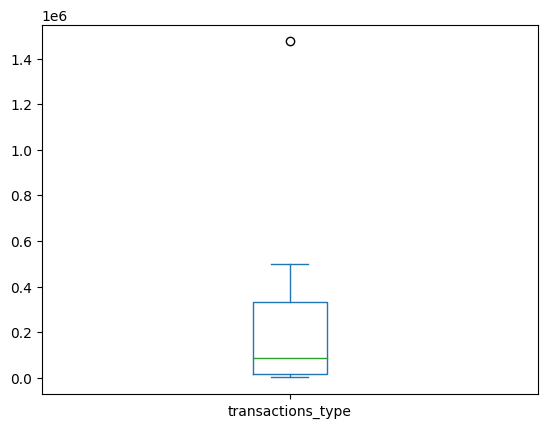

In [53]:
transactions_df['transactions_type'].value_counts().plot(kind='box')

**La majorités des transactions en nombre sont des paiements par carte suivi par les tansferts et les recharges du compte.
faire un graph avec pour filtrer l'user, voir ses transactions sur la durée en fonction du type de transaction


# Transactions_currency

In [54]:
##transactions_currency
nb_t_cur_df = transactions_df['transactions_currency'].value_counts()
nb_t_cur_df

EUR    1160135
GBP     887795
PLN     231583
RON     167806
USD      80639
CZK      44970
CHF      39716
SEK      26804
AUD      16871
NOK      14271
DKK      14058
CAD       8772
HUF       8408
TRY       4429
AED       3774
NZD       3727
ILS       3563
BTC       3327
JPY       3200
XRP       2932
ZAR       2897
SGD       2207
THB       2159
HKD       1818
ETH       1145
MAD        925
LTC        584
BCH        326
QAR        314
HRK        287
BGN        257
MXN        159
INR        148
RUB         58
SAR         11
Name: transactions_currency, dtype: int64

<Axes: >

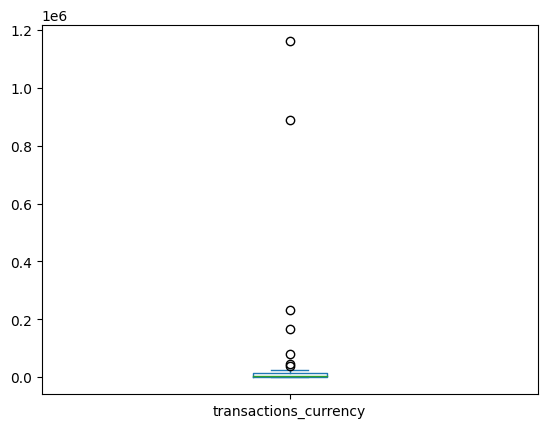

In [55]:
transactions_df['transactions_currency'].value_counts().plot(kind='box')

** Majoritée des transactions en euro ou GBP. A mettre en relation avec la table client **

# Transactions_state

In [56]:
##transactions_state
nb_t_sate_df = transactions_df['transactions_state'].value_counts()
nb_t_sate_df

COMPLETED    2407968
DECLINED      155286
REVERTED      112618
FAILED         41053
PENDING        21492
CANCELLED       1658
Name: transactions_state, dtype: int64

In [57]:
nb_t_sate_df.describe()

count    6.000000e+00
mean     4.566792e+05
std      9.576974e+05
min      1.658000e+03
25%      2.638225e+04
50%      7.683550e+04
75%      1.446190e+05
max      2.407968e+06
Name: transactions_state, dtype: float64

<Axes: >

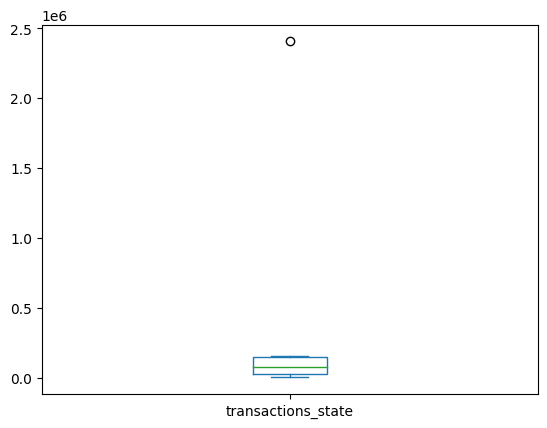

In [58]:
##transactions_state_graph
transactions_df['transactions_state'].value_counts().plot(kind='box')

** Majotié sont completes. A mettre en relation avec le nbre d'opérations par clients, le device. - faire un graph avec pour filtrer l'user, voir ses transactions sur la durée en fonctions des statuts **

# Transactions_state

In [59]:
##transactions_state
nb_t_card = transactions_df['ea_cardholderpresence'].value_counts()
nb_t_card


FALSE      1275460
TRUE        288489
UNKNOWN       5532
Name: ea_cardholderpresence, dtype: int64

In [60]:
nb_t_card.describe()

count    3.000000e+00
mean     5.231603e+05
std      6.666950e+05
min      5.532000e+03
25%      1.470105e+05
50%      2.884890e+05
75%      7.819745e+05
max      1.275460e+06
Name: ea_cardholderpresence, dtype: float64

<Axes: >

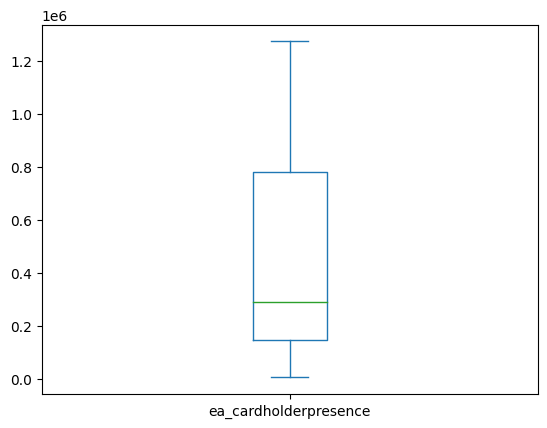

In [61]:
transactions_df['ea_cardholderpresence'].value_counts().plot(kind="box")

** Peu d'user détienne une carte - relation avec nombre de transaction. Filtre à mettre - voir si relation avec age/pays- table notification - déterminer à partir de quand utilisation de la carte **

# ea_merchant_mcc

In [62]:
##ea_merchant_mcc
nb_t_merchant_df = transactions_df['ea_merchant_mcc'].value_counts()
nb_t_merchant_df

5812.0    230209
5411.0    225700
5814.0     98509
6011.0     93783
4121.0     66692
           ...  
3523.0         1
3267.0         1
3598.0         1
4813.0         1
3788.0         1
Name: ea_merchant_mcc, Length: 664, dtype: int64

In [63]:
nb_t_merchant_df.describe()

count       664.000000
mean       2381.652108
std       14674.101385
min           1.000000
25%           4.000000
50%          29.000000
75%         258.250000
max      230209.000000
Name: ea_merchant_mcc, dtype: float64

<Axes: >

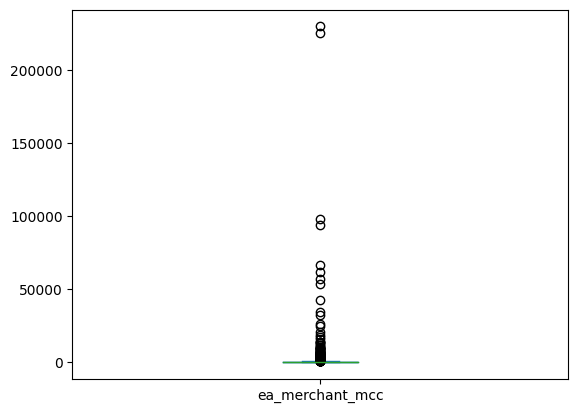

In [64]:
transactions_df['ea_merchant_mcc'].value_counts().plot(kind='box')

Pas de sens si on ne lie pas à une table MCC
a voir si on garde ou supprime

# Ea_merchant_city

In [65]:
##ea_merchant_city
nb_t_city_df = transactions_df['ea_merchant_city'].value_counts()
nb_t_city_df

London           92745
Bucuresti        33227
Vilnius          30379
Dublin           25246
35314369001      23157
                 ...  
75parisbbb115        1
75paris 15 Be        1
Triftern             1
Belford Roxo         1
Overport             1
Name: ea_merchant_city, Length: 63253, dtype: int64

In [66]:
nb_t_city_df.describe()

count    63253.000000
mean        24.999304
std        510.507568
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      92745.000000
Name: ea_merchant_city, dtype: float64

<Axes: >

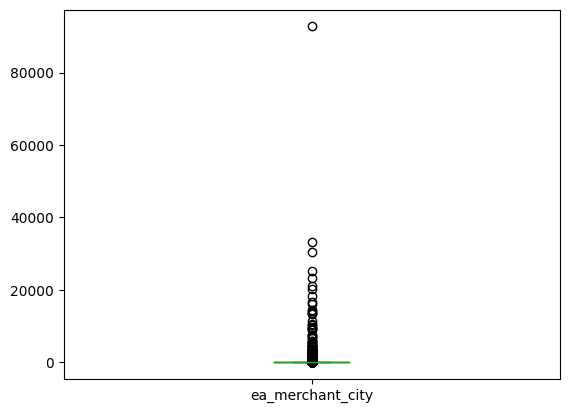

In [67]:
transactions_df['ea_merchant_city'].value_counts().plot(kind='box')

# Ea_merchant_country

In [68]:
##ea_merchant_country
nb_t_country_df = transactions_df['ea_merchant_country'].value_counts()
nb_t_country_df

GBR    455924
IRL    122993
USA    100203
FRA     99637
POL     83431
        ...  
SCH         1
LSO         1
PGB         1
GNQ         1
TGO         1
Name: ea_merchant_country, Length: 198, dtype: int64

In [69]:
nb_t_country_df.describe()

count       198.000000
mean       7985.333333
std       36059.312486
min           1.000000
25%          28.500000
50%         189.500000
75%        3173.750000
max      455924.000000
Name: ea_merchant_country, dtype: float64

** intéressant même si la majorité des transactions se fait en euro, les pays receveurs sont GBR/IRL/USA. a rapporcher avec les clients et leurs nationalités et leur pays

ces données pour être raprochée avec pib/pays **

# Direction

In [70]:
##direction
nb_t_direction_df = transactions_df['direction'].value_counts()
nb_t_direction_df

OUTBOUND    2209795
INBOUND      530280
Name: direction, dtype: int64

In [71]:
nb_t_direction_df.describe()

count    2.000000e+00
mean     1.370038e+06
std      1.187596e+06
min      5.302800e+05
25%      9.501588e+05
50%      1.370038e+06
75%      1.789916e+06
max      2.209795e+06
Name: direction, dtype: float64

<Axes: >

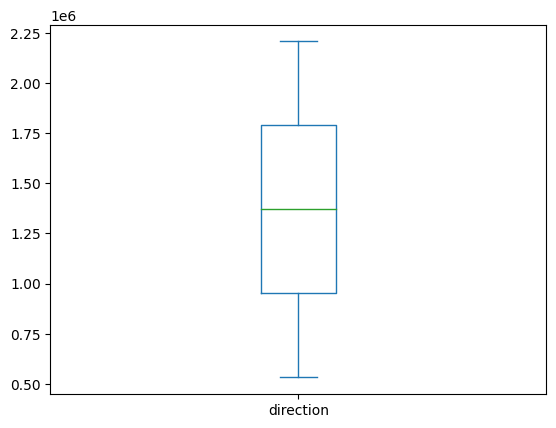

In [72]:
transactions_df['direction'].value_counts().plot(kind='box')

** a voir pour chaque utilisataire pour compter l'activité du compte
faire une table utilistaure/nombre de transactions outbound/nombre de transactions inbound **

# Users

In [73]:
##users
nb_t_users_df = transactions_df['user_id'].value_counts()
nb_t_users_df

user_12657    5285
user_4243     3381
user_10794    3223
user_1285     3056
user_10869    2913
              ... 
user_11996       1
user_10546       1
user_4398        1
user_3244        1
user_13835       1
Name: user_id, Length: 18766, dtype: int64

In [74]:
nb_t_users_df.describe()

count    18766.000000
mean       146.012736
std        245.809785
min          1.000000
25%         17.000000
50%         60.000000
75%        166.000000
max       5285.000000
Name: user_id, dtype: float64

<Axes: >

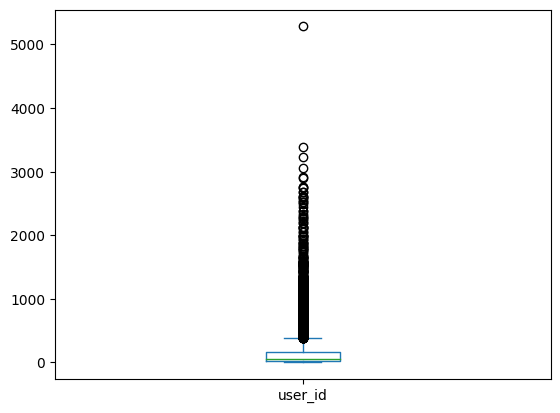

In [75]:
transactions_df['user_id'].value_counts().plot(kind ='box')

** la plupart des utilisateurs font peu de transactions. Notre but augmenter le nombre de transactions par utilisateur pour déplacer notre droite vers la droite

a voir la colonne plan dans users si elle est connectee aux nombres de transactions et/ou au montant **

In [76]:
#on va créer un goup by id, ce sera utile
user_grp = transactions_df.groupby(['user_id'])

In [77]:
#Nombre de transactions par users
user_grp['transaction_id'].describe()

,count,unique,top,freq
user_id,,,,
user_0,389,389,transaction_1063127,1
user_1,129,129,transaction_1411884,1
user_10,1053,1053,transaction_1190695,1
user_100,133,133,transaction_670100,1
user_1000,39,39,transaction_545739,1
...,...,...,...,...
user_9995,984,984,transaction_1271723,1
user_9996,240,240,transaction_58969,1
user_9997,83,83,transaction_688573,1


In [78]:
#Nombre de transactions par type et par users
user_grp['transactions_type'].describe()

,count,unique,top,freq
user_id,,,,
user_0,389,7,CARD_PAYMENT,217
user_1,129,5,CARD_PAYMENT,83
user_10,1053,7,CARD_PAYMENT,410
user_100,133,5,CARD_PAYMENT,100
user_1000,39,4,TOPUP,16
...,...,...,...,...
user_9995,984,7,TRANSFER,493
user_9996,240,6,EXCHANGE,100
user_9997,83,6,TRANSFER,43


In [79]:
#Nombre de tansactions par monnaie et par users
user_grp['transactions_currency'].describe()

,count,unique,top,freq
user_id,,,,
user_0,389,5,PLN,207
user_1,129,1,GBP,129
user_10,1053,1,EUR,1053
user_100,133,2,GBP,132
user_1000,39,3,GBP,26
...,...,...,...,...
user_9995,984,3,EUR,981
user_9996,240,5,CHF,153
user_9997,83,1,EUR,83


In [80]:
#Nombre de transactions par statut et par users
user_grp['transactions_state'].describe()

,count,unique,top,freq
user_id,,,,
user_0,389,4,COMPLETED,350
user_1,129,4,COMPLETED,114
user_10,1053,5,COMPLETED,846
user_100,133,3,COMPLETED,110
user_1000,39,4,COMPLETED,35
...,...,...,...,...
user_9995,984,6,COMPLETED,947
user_9996,240,3,COMPLETED,237
user_9997,83,4,COMPLETED,77


In [81]:
#Nombre de transactions par detenteurs de cartes et par users
user_grp['ea_cardholderpresence'].describe()

,count,unique,top,freq
user_id,,,,
user_0,224,2,FALSE,182
user_1,83,2,FALSE,79
user_10,448,3,FALSE,382
user_100,104,2,FALSE,100
user_1000,1,1,FALSE,1
...,...,...,...,...
user_9995,442,3,FALSE,399
user_9996,103,3,FALSE,84
user_9997,29,2,FALSE,21


In [82]:
#Nombre de transactions par mcc (achat) et par users
user_grp['ea_merchant_mcc'].describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
user_0,226.0,5872.884956,957.037310,1731.0,5499.00,5812.0,5947.00,8699.0
user_1,84.0,5948.833333,1108.852037,4111.0,5449.25,5813.5,5977.00,9402.0
user_10,451.0,5547.629712,1470.996319,763.0,5331.00,5541.0,5988.00,9405.0
user_100,104.0,5987.057692,1007.449137,4111.0,5542.00,5812.0,5958.75,9405.0
user_1000,1.0,6211.000000,NaN,6211.0,6211.00,6211.0,6211.00,6211.0
...,...,...,...,...,...,...,...,...
user_9995,448.0,6027.598214,964.773460,742.0,5411.00,5999.0,6011.00,8062.0
user_9996,103.0,5736.737864,1014.362863,3245.0,5520.00,5812.0,5947.00,8099.0
user_9997,30.0,6103.100000,805.454909,5499.0,5541.00,5814.0,5933.00,7995.0


In [83]:
#Nombre de transactions par villes et par users
user_grp['ea_merchant_city'].describe()

,count,unique,top,freq
user_id,,,,
user_0,226,57,Gdansk,29
user_1,84,30,New York,24
user_10,451,93,Paris,173
user_100,104,51,Fornells,9
user_1000,1,1,Internet,1
...,...,...,...,...
user_9995,448,62,+3562226800,82
user_9996,103,42,Poznan,9
user_9997,30,14,Drogheda,10


In [84]:
#Nombre de transactions par pays et par users
user_grp['ea_merchant_country'].describe()

,count,unique,top,freq
user_id,,,,
user_0,226,12,GRC,67
user_1,84,5,USA,33
user_10,451,21,FRA,331
user_100,104,8,FRA,37
user_1000,1,1,CYP,1
...,...,...,...,...
user_9995,448,17,MLT,320
user_9996,103,9,ITA,30
user_9997,30,4,IRL,18


In [85]:
#Nombre de transactions par flux entrant/sortant et par users
user_grp['direction'].describe()

,count,unique,top,freq
user_id,,,,
user_0,389,2,OUTBOUND,320
user_1,129,2,OUTBOUND,97
user_10,1053,2,OUTBOUND,769
user_100,133,2,OUTBOUND,108
user_1000,39,2,OUTBOUND,23
...,...,...,...,...
user_9995,984,2,OUTBOUND,943
user_9996,240,2,OUTBOUND,212
user_9997,83,2,OUTBOUND,71


In [86]:
#Moyenne des transactions par users en $
user_grp['amount_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
user_0,389.0,35.176787,66.833649,0.00,3.1500,8.430,39.770,582.18
user_1,129.0,47.316899,63.369764,0.00,7.8700,23.650,50.000,350.00
user_10,1053.0,49.525109,173.066372,0.00,5.1000,12.770,42.550,2947.24
user_100,133.0,156.224211,180.201766,0.55,22.8300,85.490,242.400,709.21
user_1000,39.0,552.944615,348.723115,1.00,250.0000,500.000,960.425,1000.03
...,...,...,...,...,...,...,...,...
user_9995,984.0,46.735965,306.869730,0.00,0.6150,4.260,17.020,8510.65
user_9996,240.0,69.556625,89.864732,0.53,14.8575,37.320,79.515,663.29
user_9997,83.0,10.977229,13.352181,0.00,0.6850,7.400,13.340,57.46


In [ ]:
#Moyenne des transactions par users
#user_grp['created_date'].describe()

#Created-date

In [91]:
nb_t_par_jour_df = transactions_df['created_date'].value_counts()
nb_t_par_jour_df

2018-12-04 12:13:34.572326+00:00    4
2018-12-22 07:24:30.960017+00:00    3
2018-12-13 14:49:24.314528+00:00    3
2019-05-09 08:48:56.864973+00:00    3
2018-10-25 10:06:43.624650+00:00    3
                                   ..
2019-02-22 05:20:38.821686+00:00    1
2018-10-21 07:22:34.766171+00:00    1
2018-08-11 06:50:11.613606+00:00    1
2018-09-10 01:33:24.315097+00:00    1
2019-04-11 12:21:16.181703+00:00    1
Name: created_date, Length: 2739658, dtype: int64

In [92]:
nb_t_par_jour_df.describe()

count    2.739658e+06
mean     1.000152e+00
std      1.254176e-02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.000000e+00
Name: created_date, dtype: float64

In [ ]:
transactions_df['created_date'].value_counts().plot(kind='bar')

# 3.2.1. La variable qualitative de la table transaction


# Amount_usd

In [ ]:
# Amount_usd
print(transactions_df['amount_usd'].min())
print(transactions_df['amount_usd'].max())
print(transactions_df['amount_usd'].mean())
print(transactions_df['amount_usd'].median())
print(transactions_df['amount_usd'].mode())
print(transactions_df['amount_usd'].var())
print(transactions_df['amount_usd'].std())


0.0
85106453190.03
170322.4872953989
8.51
0    0.0
Name: amount_usd, dtype: float64
9281423266317788.0
96340143.58676133


le max parraît erroné et fausse notre moyenne d'où l'intérêt de notre médiane à 8.51. Il va falloir s'intérroger sur les valeurs abérantes. ce qui entraine un énorme écart type.

<Axes: ylabel='Frequency'>

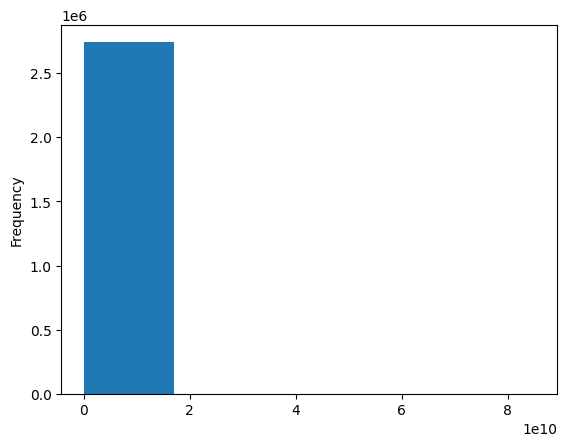

In [ ]:
transactions_df['amount_usd'].plot.hist(bins=5)

Distibution anormal on peut le verifier avec la boite à moustache

<Axes: >

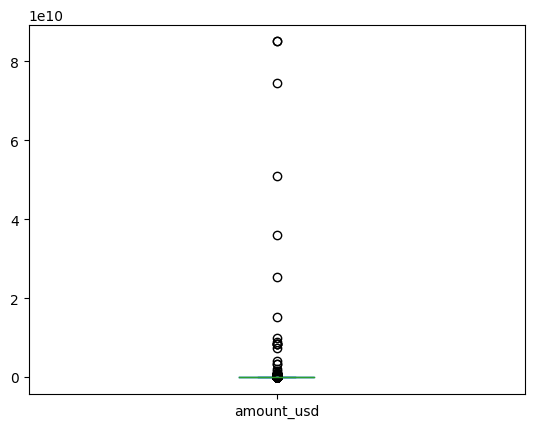

In [ ]:
transactions_df['amount_usd'].plot.box()

Détections des valeurs abbérantes(Outliers)

In [ ]:
# on calcule les quartiles
Q1= transactions_df['amount_usd'].quantile(0.25)
Q3 = transactions_df['amount_usd'].quantile(0.75)
IQR= Q3-Q1
coef = IQR*1.5

In [ ]:
#on calcule les valeurs limites
lim_inf = Q1-coef
lim_sup = Q3 + coef

In [ ]:
#on cherche les outliers
result = transactions_df[(transactions_df['amount_usd']>lim_sup )|(transactions_df['amount_usd']<lim_inf)]
result

In [ ]:
#filtre colonnes
result.sort_values("amount_usd")

#**4.Preprocessing**
```



** faut-il effacer les valeurs abbérantes ou faire des sous groupes par pays/âge et refaire les calculs d'abérances.
 Il faut d'abrod trier par pays et utilisateurs. il faut d'abord regarder toutes les tables avant de les nettoyer.
Si l'on souhaite le faire:

transactions_df=transactions_df[(transactions_df['amount_usd']<= lim_sup)&(transactions_df['amount_usd']>= lim_inf)]

on peut après refaire un plot.hist **

je viens de m'appercevoir que la fonction describe(): données les données stats: count, mean, std, min, 25%, 50%,75%, max ;-) à utiliser par la suite

In [ ]:
#created_date
#description de la colonne date
transactions_df['created_date'].describe()

<ipython-input-55-03234685df8b>:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  transactions_df['created_date'].describe()


count                              2740075
unique                             2739658
top       2018-12-04 12:13:34.572326+00:00
freq                                     4
first     2018-01-01 08:51:10.248709+00:00
last      2019-05-16 18:22:16.959896+00:00
Name: created_date, dtype: object

#**5.Training**
a refaire après nettoyage c'est pour avoir la trame

#5.1. Model

#5.2. Optimization

In [ ]:
##STATS
from scipy.stats import ttest_1samp # utiliser pour une variable quantitative dans un echantillon
from scipy.stats import f_oneway # anova 1 facteurs pour étudier corrélation entre variable quantitative et qualitative
from scipy.stats import chi2_contingency # pour cére table de corrélation entre 2 variables qualitatives
from scipy.stats import chi2 #étudier corrélation entre 2 variables qualitatives
from scipy.stats import pearsonr # corrélation 2 variables quantitatives


Nou souhaitons connaître la corrélation entre

le nombre de transactions est:
- le type de transaction
- la monnaie de transaction
- le statut de la transaction
- avoir une carte
- le style d'achat effectué(mcc)
- le merchant city
- le merchant country
- le nombre d'opération rentrante
test
- le montant de la transaction

test de ma variable quantitative : amound-usd avec mediane, la moyenne n'éta,t pas représentatrice

In [ ]:
transactions_df['amount_usd'].median()

8.51

On veut faire un test statistique pour vérifier si la mediane de taille de notre échantillon est connecte par rapport à la population.



je le fais pour apprendre

** test à faire après l'échantillonnage et le nettoyage des tables **

In [ ]:
#H0: la mediane des transaction est égale à 8.51$
#H1: la médiane des transactions n'est pas égale à 8.51$

In [ ]:
tset, pval = ttest_1samp(transactions_df['amount_usd'],8.51 )
print("p-values",pval)
if pval<0.05:
  print("we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

p-values 0.0034298282807220634
we are rejecting null hypothesis


** la médiane des transactions n'est pas égale à 8.51

```
# Ce texte est au format code
```



#3-1.Correlation entre une variable quantitative et qualitative

---



On veut savoir s'il y a une relation entre le montant des transactions et le type de transactions

h0: pas de relation entre le montant des transactions et le type de transaction

h1: il y a corrélation entre le montant des transactions et le type de transaction

In [ ]:
#ANOVA(F_TEST)
query = "SELECT * FROM `pro-tuner-402908.neo_bank.transactions`"
id = "pro-tuner-402908"
df_anova = pd.read_gbq(query, project_id = id)



In [ ]:
df_anova = df_anova[['amount_usd', 'transactions_type']]
grps = pd.unique(df_anova.transactions_type.values)
print(grps)
d_data = {grp:df_anova['amount_usd'][df_anova.transactions_type.values == grp] for grp in grps}
print(d_data)

['TOPUP' 'EXCHANGE' 'TRANSFER' 'CARD_PAYMENT' 'CARD_REFUND' 'ATM'
 'CASHBACK' 'REFUND' 'FEE' 'TAX']
{'TOPUP': 0          6079.39
1           298.64
2           236.63
244        1065.83
245         213.17
            ...   
2739878      34.38
2739879       0.05
2739880     634.66
2739881      84.62
2739882      50.35
Name: amount_usd, Length: 388331, dtype: float64, 'EXCHANGE': 3           69.92
4           52.24
5            0.14
6          110.82
7            0.41
            ...  
2739905      1.06
2739906      0.53
2739907    326.50
2739908      0.53
2739909      0.53
Name: amount_usd, Length: 159148, dtype: float64, 'TRANSFER': 38         639.31
39           6.41
40           2.07
41           6.20
42         309.97
            ...  
2739914     16.42
2739915     17.98
2739916     28.03
2739917     26.44
2739918      6.35
Name: amount_usd, Length: 500409, dtype: float64, 'CARD_PAYMENT': 46          11.16
47           9.40
48           3.93
49          13.02
50          15.50
     

In [ ]:
transactions_df['transactions_type'].unique()

array(['TOPUP', 'EXCHANGE', 'TRANSFER', 'CARD_PAYMENT', 'CARD_REFUND',
       'ATM', 'CASHBACK', 'REFUND', 'FEE', 'TAX'], dtype=object)

In [ ]:
F,p = f_oneway(d_data['TOPUP'],
               d_data['EXCHANGE'],
               d_data['TRANSFER'],
               d_data['CARD_PAYMENT'],
               d_data['CARD_REFUND'],
               d_data['ATM'],
               d_data['CASHBACK'],
               d_data['REFUND'],
               d_data['FEE'],
               d_data['TAX'])
print("p-value for signifiance is:",p)
if p<0.5:
  print("reject null hypothesis")
else:
  print("accept null hypothesis")

p-value for signifiance is: 1.537824290965327e-05
reject null hypothesis


** ho est rejeté: il y a donc une corrélation entre le montant des transactions et le type de paiement.**

# 3-2.Correlation entre deux variables qualitatives

On souhaite maintenant étudier la corrélation entre les transactions-type et les transactions-statuts

In [ ]:
contingency_table=pd.crosstab(transactions_df["transactions_type"],transactions_df["transactions_state"])
print("contingency_table:-\n",contingency_table)

contingency_table:-
 transactions_state  CANCELLED  COMPLETED  DECLINED  FAILED  PENDING  REVERTED
transactions_type                                                            
ATM                         0      77824     14537       0      370       944
CARD_PAYMENT                0    1257461    133469       0    19055     65795
CARD_REFUND                 0      11960         2       0        0         0
CASHBACK                    0      76713      4043       0     2033         0
EXCHANGE                    0     159146         0       0        0         2
FEE                         0      23659         0       0        0         0
REFUND                      0       1493         0       0        0         0
TAX                         0       2794         0       0       18        17
TOPUP                       0     303750         0   40863        3     43715
TRANSFER                 1658     493168      3235     190       13      2145


<Figure size 640x480 with 0 Axes>

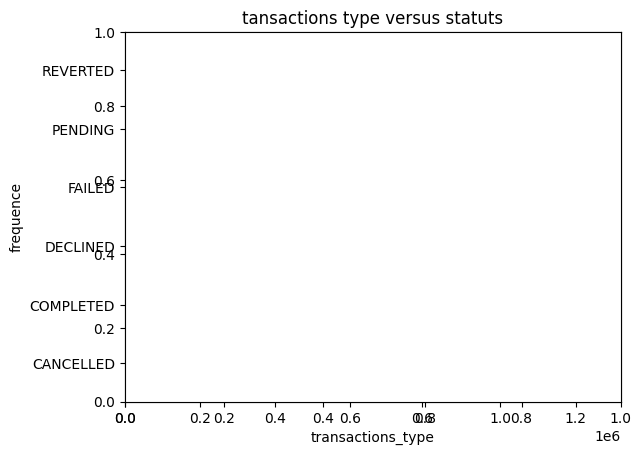

In [ ]:
fig=plt.figure()
contingency_table.T.plot(kind='barh',ylabel = 'frequence',width=0.8)

plt.title('tansactions type versus statuts')
ax=plt.axes()
ax=ax.set(xlabel='transactions_type')


In [ ]:
#ho: pas de relation entre le type de transaction et le statut
#h1: il y a une relation entre le type et le statut des transactions

In [ ]:
#Chi-square test d'independance.
c, p, dof, expected = chi2_contingency(contingency_table)
# Print the p-value
print(p)

0.0


** on va donc rejeter h0, il y a une relation entre le type et le statut dans les transactions**

In [ ]:
#Observation des valeurs
Observed_Values = contingency_table.values
print("Observed_Values:-\n",Observed_Values)

Observed_Values:-
 [[      0   77824   14537       0     370     944]
 [      0 1257461  133469       0   19055   65795]
 [      0   11960       2       0       0       0]
 [      0   76713    4043       0    2033       0]
 [      0  159146       0       0       0       2]
 [      0   23659       0       0       0       0]
 [      0    1493       0       0       0       0]
 [      0    2794       0       0      18      17]
 [      0  303750       0   40863       3   43715]
 [   1658  493168    3235     190      13    2145]]


In [ ]:
#si il n'y a pas de relation les valeurs ce que l'on aurait
b = chi2_contingency(contingency_table)
Expected_Values = b[3]
print("Expected_Values:-\n",Expected_Values)

Expected_Values:-
 [[5.66820799e+01 8.23212512e+04 5.30876565e+03 1.40347975e+03
  7.34747443e+02 3.85007387e+03]
 [8.92984039e+02 1.29691013e+06 8.36356571e+04 2.21107803e+04
  1.15753999e+04 6.06550522e+04]
 [7.23812158e+00 1.05121623e+04 6.77912514e+02 1.79219907e+02
  9.38249150e+01 4.91642205e+02]
 [5.00950383e+01 7.27546738e+04 4.69183240e+03 1.24038094e+03
  6.49362221e+02 3.40265562e+03]
 [9.62993290e+01 1.39858687e+05 9.01926273e+03 2.38442482e+03
  1.24829022e+03 6.54103609e+03]
 [1.43158935e+01 2.07914436e+04 1.34080690e+03 3.54469468e+02
  1.85571281e+02 9.72392822e+02]
 [9.03403739e-01 1.31204300e+03 8.46115519e+01 2.23687779e+01
  1.17104663e+01 6.13627999e+01]
 [1.71180789e+00 2.48611497e+03 1.60325573e+02 4.23853132e+01
  2.21894904e+01 1.16272847e+02]
 [2.34976341e+02 3.41263878e+05 2.20075610e+04 5.81814459e+03
  3.04590562e+03 1.59605341e+04]
 [3.02793946e+02 4.39757619e+05 2.83592646e+04 7.49734612e+03
  3.92499849e+03 2.05669775e+04]]


In [ ]:
#Calcul du degré de liberté:
#on multiplie nombre de colonne par nombre de ligne
no_of_rows=len(contingency_table.iloc[:,0])
no_of_columns = len(contingency_table.iloc[0,:])
ddof=(no_of_rows-1)*(no_of_columns-1)
print("Degree of Freedom:",ddof)

Degree of Freedom: 45


autre méthode pour faire le test de cintingency

In [ ]:
alpha = 0.05
chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values, Expected_Values)])
chi_square_statistic = chi_square[0]+chi_square[1]
print("chi-square statistic:-", chi_square_statistic)
critical_value=chi2.ppf(q=1-alpha,df=ddof)
print('critical_value:',critical_value)
#p-value
p_value = 1-chi2.cdf(x=chi_square_statistic,df=ddof)
print('p_value:',p_value)
print('Significiance level:',alpha)
print('Degree of Freedom:',ddof)
print('chi_square_statistic:',chi_square_statistic)
print('critical_value:',critical_value)
print('p_value:',p_value)
if chi_square_statistic>= critical_value:
  print("Rejet H0, Il y a une relation entre les 2 catégories")
else:
  print("On retient H0, Il n'y a pas de relation entre les 2 catégories")

if p_value<= alpha:
  print("Rejet H0, Il y a une relation entre les 2 catégories")
else:
  print("On retient H0, Il n'y a pas de relation entre les 2 catégories")




chi-square statistic:- 23010.157838094325
critical_value: 61.65623337627955
p_value: 0.0
Significiance level: 0.05
Degree of Freedom: 45
chi_square_statistic: 23010.157838094325
critical_value: 61.65623337627955
p_value: 0.0
Rejet H0, Il y a une relation entre les 2 catégories
Rejet H0, Il y a une relation entre les 2 catégories


#**6.Implement in product**